# Get raw data data from google cloud storage

In [13]:
# Import the Google Cloud client library and JSON library
from google.cloud import storage
import json

In [38]:
# Instantiate a Google Cloud Storage client and specify required bucket and file
storage_client = storage.Client()
bucket = storage_client.get_bucket('opengeokpi-bucket')

In [39]:
# get blobs
blob_departements = bucket.blob('refine/territory/departements.json')

In [40]:
# Download the contents of the blob as a string and then parse it using json.loads() method
data_departements = json.loads(blob_departements.download_as_string(client=None))

# Prepare data

In [41]:
import geopandas as gpd
from shapely import wkt

In [42]:
# convert geojson to geopandadataframe
gdf_departements = gpd.GeoDataFrame.from_features(data_departements["features"])

In [43]:
# set crs
gdf_departements = gdf_departements.set_crs(epsg=4326)

In [67]:
gdf_departements.head()

,geometry,departements_area,departements_code,departements_level,departements_name,departements_population
0,"MULTIPOLYGON (((5.80669 46.04423, 5.80887 46.0...",5762.0,01,fr:departement,Ain,631877.0
1,"MULTIPOLYGON (((3.07681 49.35563, 3.07741 49.3...",7369.0,02,fr:departement,Aisne,538659.0
2,"MULTIPOLYGON (((3.23258 46.06980, 3.22433 46.0...",7340.0,03,fr:departement,Allier,341613.0
3,"MULTIPOLYGON (((5.65458 43.82504, 5.64606 43.8...",6925.0,04,fr:departement,Alpes-de-Haute-Provence,161799.0
4,"MULTIPOLYGON (((6.88366 44.84781, 6.88811 44.8...",5549.0,05,fr:departement,Hautes-Alpes,140916.0


In [68]:
# select paris
gdf_departements_paris =  gdf_departements[gdf_departements.departements_code == '75']
gdf_departements_paris.head()

,geometry,departements_area,departements_code,departements_level,departements_name,departements_population
75,"MULTIPOLYGON (((2.22569 48.85944, 2.22824 48.8...",NaN,75,fr:departement,Paris,NaN


<AxesSubplot:>

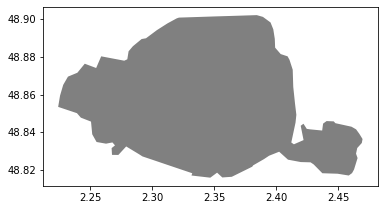

In [69]:
import matplotlib.pyplot as plt
gdf_departements_paris.plot(facecolor='gray')

# rasterize paris

In [47]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

In [48]:
xmin,ymin,xmax,ymax = gdf_departements_paris.total_bounds
print(xmin,ymin,xmax,ymax)

2.224169 48.815865 2.46976 48.902156


In [49]:
# define final resolution 
length = 0.001
wide = 0.00125 

# define working resolution 
#length = 0.01
#wide = 0.0125 

In [50]:
np.arange(xmin,xmax,wide)
cols = list(np.arange(xmin,xmax,wide))
rows = list(np.arange(ymin,ymax,length))
rows.reverse()

In [51]:
polygons = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )

grid = gpd.GeoDataFrame({'geometry':polygons})

In [52]:
# set crs
grid = grid.set_crs(epsg=4326)

In [53]:
# Add Id column
grid['ID'] = grid.index + 1
grid.head()

,geometry,ID
0,"POLYGON ((2.22417 48.90186, 2.22542 48.90186, ...",1
1,"POLYGON ((2.22417 48.90086, 2.22542 48.90086, ...",2
2,"POLYGON ((2.22417 48.89986, 2.22542 48.89986, ...",3
3,"POLYGON ((2.22417 48.89886, 2.22542 48.89886, ...",4
4,"POLYGON ((2.22417 48.89786, 2.22542 48.89786, ...",5


In [54]:
grid_centroid = grid.copy()
grid_centroid.head()

,geometry,ID
0,"POLYGON ((2.22417 48.90186, 2.22542 48.90186, ...",1
1,"POLYGON ((2.22417 48.90086, 2.22542 48.90086, ...",2
2,"POLYGON ((2.22417 48.89986, 2.22542 48.89986, ...",3
3,"POLYGON ((2.22417 48.89886, 2.22542 48.89886, ...",4
4,"POLYGON ((2.22417 48.89786, 2.22542 48.89786, ...",5


In [55]:
#Find the center point
grid_centroid['Center_point'] = grid_centroid['geometry'].centroid

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [56]:
#Extract lat and lon from the centerpoint
grid_centroid["lat"] = grid_centroid.Center_point.map(lambda p: p.x)
grid_centroid["long"] = grid_centroid.Center_point.map(lambda p: p.y)
grid_centroid.head()

,geometry,ID,Center_point,lat,long
0,"POLYGON ((2.22417 48.90186, 2.22542 48.90186, ...",1,POINT (2.22479 48.90136),2.224794,48.901365
1,"POLYGON ((2.22417 48.90086, 2.22542 48.90086, ...",2,POINT (2.22479 48.90036),2.224794,48.900365
2,"POLYGON ((2.22417 48.89986, 2.22542 48.89986, ...",3,POINT (2.22479 48.89936),2.224794,48.899365
3,"POLYGON ((2.22417 48.89886, 2.22542 48.89886, ...",4,POINT (2.22479 48.89836),2.224794,48.898365
4,"POLYGON ((2.22417 48.89786, 2.22542 48.89786, ...",5,POINT (2.22479 48.89736),2.224794,48.897365


In [57]:
# convert cells geometry column to string
grid_centroid['str_geom_grid'] = grid_centroid.geometry.apply(lambda x: wkt.dumps(x))

In [58]:
grid_centroid.head()

,geometry,ID,Center_point,lat,long,str_geom_grid
0,"POLYGON ((2.22417 48.90186, 2.22542 48.90186, ...",1,POINT (2.22479 48.90136),2.224794,48.901365,POLYGON ((2.2241689999999998 48.90186499999980...
1,"POLYGON ((2.22417 48.90086, 2.22542 48.90086, ...",2,POINT (2.22479 48.90036),2.224794,48.900365,POLYGON ((2.2241689999999998 48.90086499999980...
2,"POLYGON ((2.22417 48.89986, 2.22542 48.89986, ...",3,POINT (2.22479 48.89936),2.224794,48.899365,POLYGON ((2.2241689999999998 48.89986499999980...
3,"POLYGON ((2.22417 48.89886, 2.22542 48.89886, ...",4,POINT (2.22479 48.89836),2.224794,48.898365,POLYGON ((2.2241689999999998 48.89886499999980...
4,"POLYGON ((2.22417 48.89786, 2.22542 48.89786, ...",5,POINT (2.22479 48.89736),2.224794,48.897365,POLYGON ((2.2241689999999998 48.89786499999981...


In [59]:
# convert centroid geometry column to string
grid_centroid['str_geom_centroid'] = grid_centroid.Center_point.apply(lambda x: wkt.dumps(x))
grid_centroid.head()

,geometry,ID,Center_point,lat,long,str_geom_grid,str_geom_centroid
0,"POLYGON ((2.22417 48.90186, 2.22542 48.90186, ...",1,POINT (2.22479 48.90136),2.224794,48.901365,POLYGON ((2.2241689999999998 48.90186499999980...,POINT (2.2247940000000006 48.9013649999998066)
1,"POLYGON ((2.22417 48.90086, 2.22542 48.90086, ...",2,POINT (2.22479 48.90036),2.224794,48.900365,POLYGON ((2.2241689999999998 48.90086499999980...,POINT (2.2247940000000006 48.9003649999998089)
2,"POLYGON ((2.22417 48.89986, 2.22542 48.89986, ...",3,POINT (2.22479 48.89936),2.224794,48.899365,POLYGON ((2.2241689999999998 48.89986499999980...,POINT (2.2247940000000006 48.8993649999998041)
3,"POLYGON ((2.22417 48.89886, 2.22542 48.89886, ...",4,POINT (2.22479 48.89836),2.224794,48.898365,POLYGON ((2.2241689999999998 48.89886499999980...,POINT (2.2247940000000006 48.8983649999998065)
4,"POLYGON ((2.22417 48.89786, 2.22542 48.89786, ...",5,POINT (2.22479 48.89736),2.224794,48.897365,POLYGON ((2.2241689999999998 48.89786499999981...,POINT (2.2247940000000006 48.8973649999998088)


In [60]:
# subset columns
grid_centroid_df = grid_centroid[['ID', 'str_geom_grid', 'str_geom_centroid']]

In [61]:
grid_centroid_df.shape

(17139, 3)

# Load grid data in bigquery

In [65]:
from google.cloud import bigquery

In [66]:
# connect to existing dataset

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

# Define a name for the dataset.
dataset_id = 'opengeokpi'

# The project defaults to the Client's project if not specified.
dataset = client.get_dataset(dataset_id)  # API request# create new dataset

table_ref = dataset.table("grid_centroid_df")
job = client.load_table_from_dataframe(grid_centroid_df, table_ref, location="US")

job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

Client creating using default project: test-rstudio-gcp
Loaded dataframe to /projects/test-rstudio-gcp/datasets/opengeokpi/tables/grid_centroid_df


# select points in polygon

In [70]:
import shapely.speedups
shapely.speedups.enable()
import geopandas
import descartes
import matplotlib.pyplot as plt
from geopandas.tools import sjoin

In [71]:
centroid = grid_centroid[['Center_point','ID']]
centroid = geopandas.GeoDataFrame(centroid, geometry='Center_point')
centroid.head()

,Center_point,ID
0,POINT (2.22479 48.90136),1
1,POINT (2.22479 48.90036),2
2,POINT (2.22479 48.89936),3
3,POINT (2.22479 48.89836),4
4,POINT (2.22479 48.89736),5


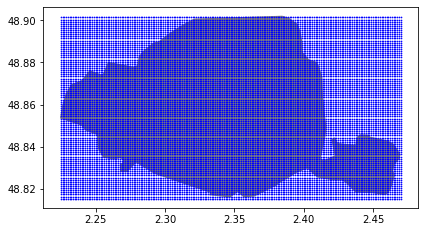

In [72]:
fig, ax = plt.subplots()
gdf_departements_paris.plot(ax=ax, facecolor='gray')
centroid.plot(ax=ax, color='blue', markersize=0.5)
plt.tight_layout()

In [73]:
# get centroids points within paris departements
pointInPolys = sjoin(centroid, gdf_departements_paris, op = 'within')

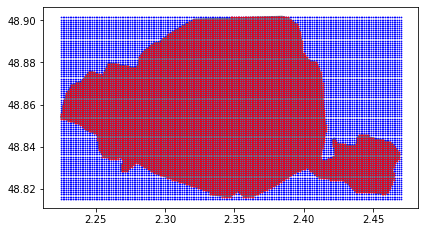

In [74]:
fig, ax = plt.subplots()
gdf_departements_paris.plot(ax=ax, facecolor='gray')
centroid.plot(ax=ax, color='blue', markersize=0.5)
pointInPolys.plot(ax=ax, color='red', markersize=0.5)
plt.tight_layout()

In [77]:
# convert centroid geometry column to string
pointInPolys['str_geom_centroid'] = pointInPolys.Center_point.apply(lambda x: wkt.dumps(x))
pointInPolys.head()

,Center_point,ID,index_right,departements_area,departements_code,departements_level,departements_name,departements_population,str_geom_centroid
46,POINT (2.22479 48.85536),47,75,NaN,75,fr:departement,Paris,NaN,POINT (2.2247940000000006 48.8553649999999067)
47,POINT (2.22479 48.85436),48,75,NaN,75,fr:departement,Paris,NaN,POINT (2.2247940000000006 48.8543649999999090)
48,POINT (2.22479 48.85336),49,75,NaN,75,fr:departement,Paris,NaN,POINT (2.2247940000000006 48.8533649999999113)
129,POINT (2.22604 48.85936),130,75,NaN,75,fr:departement,Paris,NaN,POINT (2.2260439999999999 48.8593649999998902)
130,POINT (2.22604 48.85836),131,75,NaN,75,fr:departement,Paris,NaN,POINT (2.2260439999999999 48.8583649999999068)


In [78]:
# subset columns
centroids_grid_df = pointInPolys[['ID', 'departements_code', 'departements_name','str_geom_centroid']]

In [79]:
# load results in bigquery
# connect to existing dataset

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

# Define a name for the dataset.
dataset_id = 'opengeokpi'

# The project defaults to the Client's project if not specified.
dataset = client.get_dataset(dataset_id)  # API request# create new dataset

table_ref = dataset.table("centroids_grid_df")
job = client.load_table_from_dataframe(centroids_grid_df, table_ref, location="US")

job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

Client creating using default project: test-rstudio-gcp
Loaded dataframe to /projects/test-rstudio-gcp/datasets/opengeokpi/tables/centroids_grid_df


In [80]:
centroids_grid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10335 entries, 46 to 17032
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 10335 non-null  int64 
 1   departements_code  10335 non-null  object
 2   departements_name  10335 non-null  object
 3   str_geom_centroid  10335 non-null  object
dtypes: int64(1), object(3)
memory usage: 403.7+ KB


In [82]:
# create centroids_grid_geo in bigquery
sql = """
    SELECT
  ST_GEOGFROMTEXT(str_geom_centroid) AS geom_centroids,
  ID,
  departements_code,
  departements_name
FROM
  `test-rstudio-gcp.opengeokpi.centroids_grid_df` ;
"""
table_ref = dataset.table("centroids_grid_geo")
job_config = bigquery.QueryJobConfig(
    destination=table_ref
)


# Start the query, passing in the extra configuration.
query_job = client.query(sql, location="US", job_config=job_config)

query_job.result()  # Waits for the query to finish
print("Query results loaded to table {}".format(table_ref.path))

Query results loaded to table /projects/test-rstudio-gcp/datasets/opengeokpi/tables/centroids_grid_geo
